## Team 7: Online News Popularity

**Dataset Information**: (http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)

The articles were published by Mashable (www.mashable.com) and their content as the rights to reproduce it belongs to them. Hence, this dataset does not share the original content but some statistics associated with it. The original content be publicly accessed and retrieved using the provided urls. Acquisition date: January 8, 2015 

The estimated relative performance values were estimated by the authors using a Random Forest classifier and a rolling windows as assessment method. See their article for more details on how the relative performance values were set.

Objective: **predict the number of shares in social networks (popularity)**.

**Attribute Information**:

Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field) 

In [1]:
# Import Libaries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp

warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tnrange
tqdm_notebook().pandas()

# Define Graph Styles
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
d_fontsize = 20
d_figsize = (20,8)
sns.set(rc={'figure.figsize': d_figsize})
target_name = 'Number of Shares'

# Load Data as DataFrame
csv_path = './datasets/OnlineNewsPopularity.csv'
df = pd.read_csv(csv_path)

<div class="alert alert-info" style="font-size:150%"><b>1. Clean Data</b></div>

In [2]:
# Remove Weird Spaces From Column Names
df.columns = df.columns.map(lambda x: x.replace(' ', ''))

In [3]:
# combining weekday dummy variables into single column only to plot graph

wkday = {}

wkday['Monday'] = df['weekday_is_monday']
wkday['Tuesday'] = df['weekday_is_tuesday']
wkday['Wednesday'] = df['weekday_is_wednesday']
wkday['Thursday'] = df['weekday_is_thursday']
wkday['Friday'] = df['weekday_is_friday']
wkday['Saturday'] = df['weekday_is_saturday']
wkday['Sunday'] = df['weekday_is_sunday']

weekday = pd.DataFrame(wkday)

def get_weekday(row):
    for c in weekday.columns:
        if row[c]==1:
            return c

weekday = weekday.apply(get_weekday, axis=1)

df1 = pd.concat([df,weekday],axis=1)
df1.rename(columns={0:'weekday_type'},inplace=True)
df1.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,weekday_type
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,Monday
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,Monday
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,Monday
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,Monday
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,Monday


In [4]:
# Convert Columns to Correct Data Types
boolean_columns = [column_name for column_name in df.columns if 'is' in column_name]
df[boolean_columns] = df[boolean_columns].astype(bool)

'''
['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend']
 '''

int_columns = [
    'timedelta', # Days between the article publication and the dataset acquisition
    'n_tokens_title', # Number of words in the title
    'n_tokens_content', # Number of words in the content
    'num_hrefs', # Number of links
    'num_self_hrefs', # Number of links to other articles
    'num_imgs', # Number of images
    'num_videos', # Number of videos
    'num_keywords', # Number of keywords in the metadata
    'self_reference_min_shares', # Min. shares of referenced articles in Mashable
    'self_reference_max_shares', # Max. shares of referenced articles in Mashable
]

df[int_columns] = df[int_columns].astype('int64')

<div class="alert alert-info" style="font-size:150%"><b>2. EDA</b></div>

In [5]:
print('There are {num_articles} articles'.format(num_articles = len(df)))

There are 39644 articles


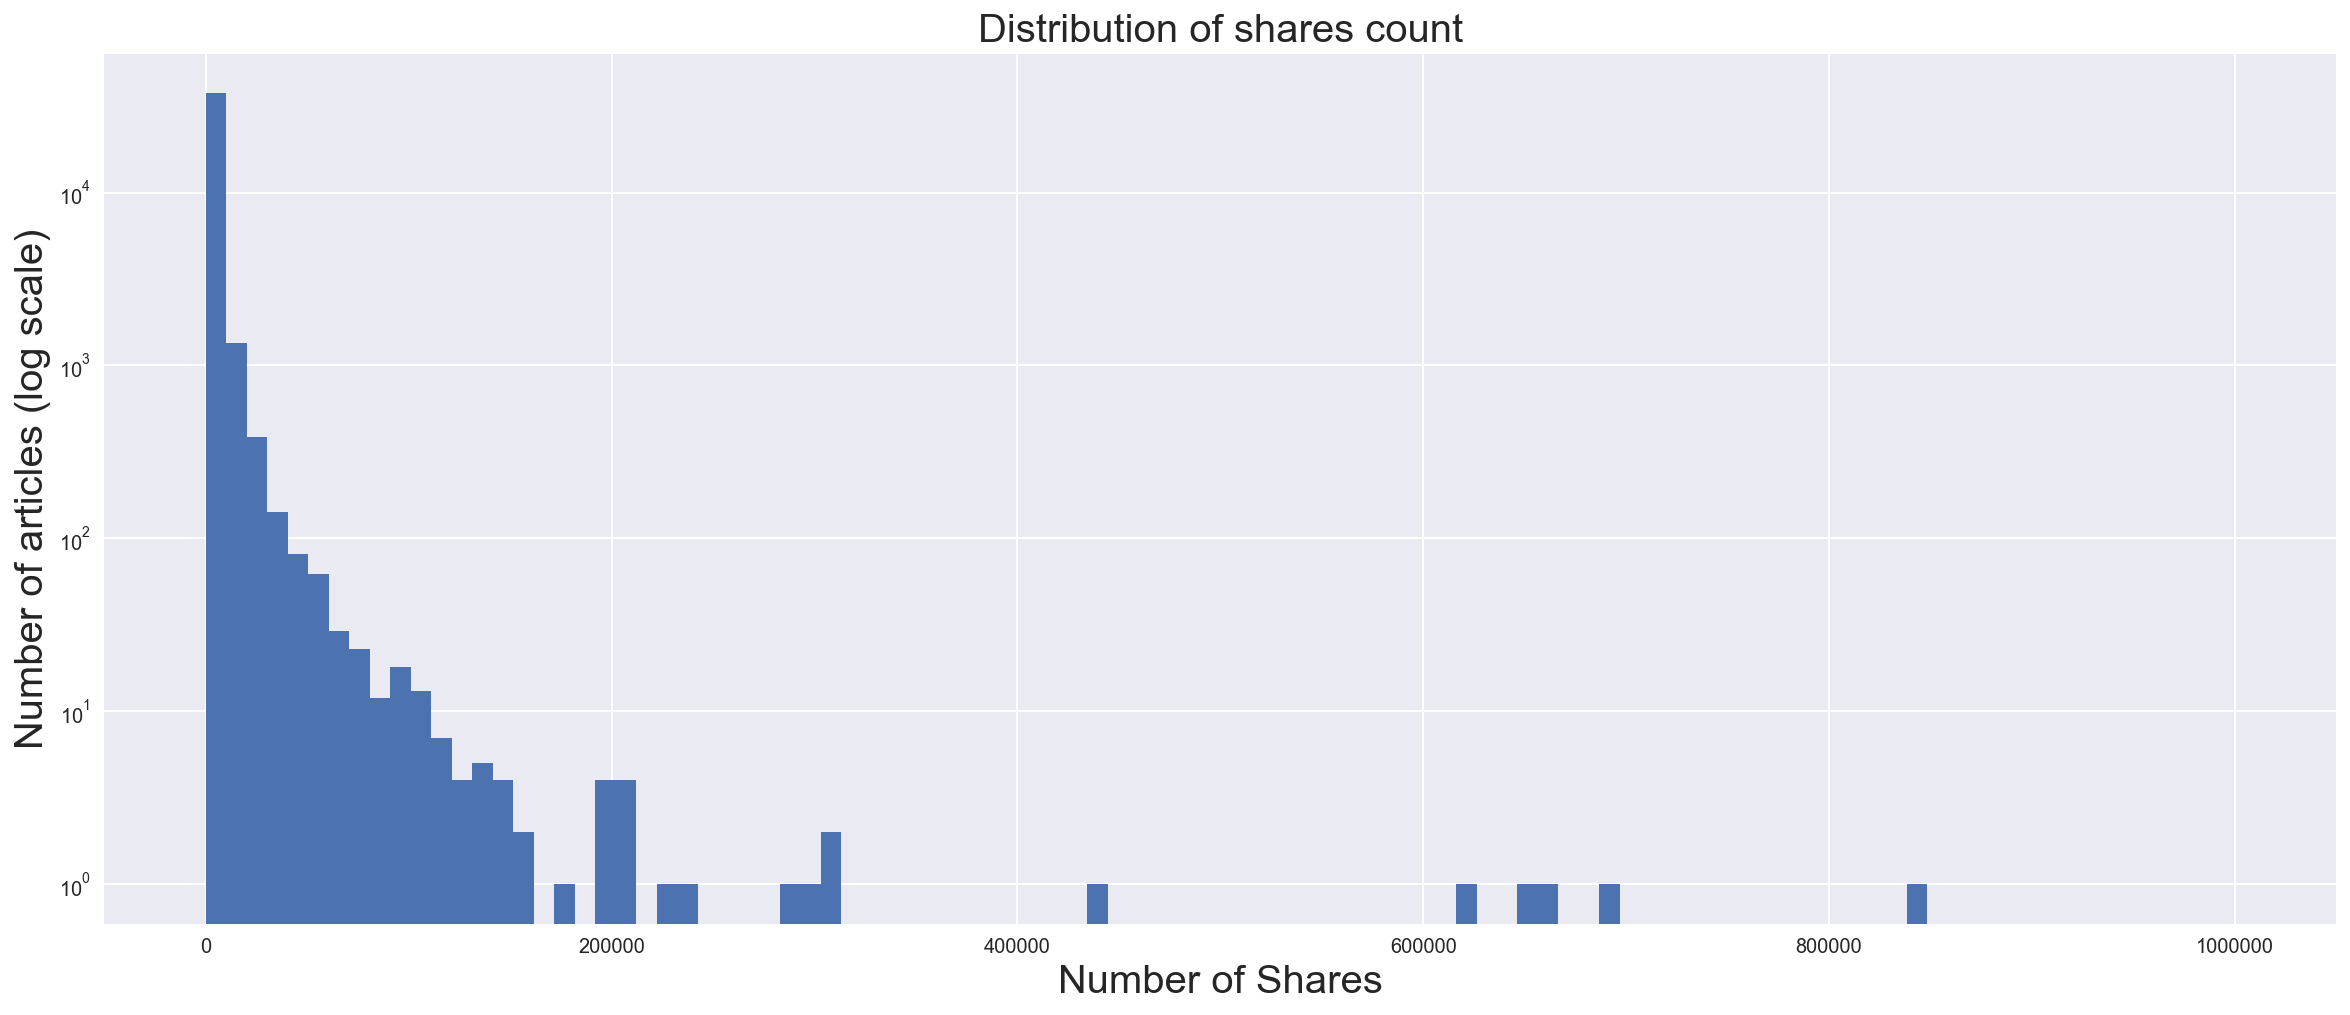

In [6]:
def plot_distribution_of_target_variable():
    plot_data = df['shares']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_title('Distribution of shares count', fontsize = d_fontsize)
    ax.set_xlabel(target_name, fontsize = d_fontsize)
    ax.set_ylabel('Number of articles (log scale)', fontsize = d_fontsize)
    ax.hist(plot_data, bins = np.linspace(0, 10**6, 10**2));
plot_distribution_of_target_variable()

<div class="alert alert-info" style="font-size:150%">Even with y-axis on log scale, distribution of shares count is still extremely skewed to the right. Thus, we create alternative target variables: <b>target_p50</b>, <b>target_p90</b> and <b>target_categories</b>.</div>

In [7]:
shares_p50 = df['shares'].quantile(0.5)
shares_p50

1400.0

<div class="alert alert-info" style="font-size:150%"><b>target_p50</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 1400 shares (50th percentile)</div>

In [8]:
df['target_p50'] = df['shares'].map(lambda x : 1 if x > shares_p50 else 0)
df[['shares', 'target_p50']].head()

,shares,target_p50
0,593,0
1,711,0
2,1500,1
3,1200,0
4,505,0


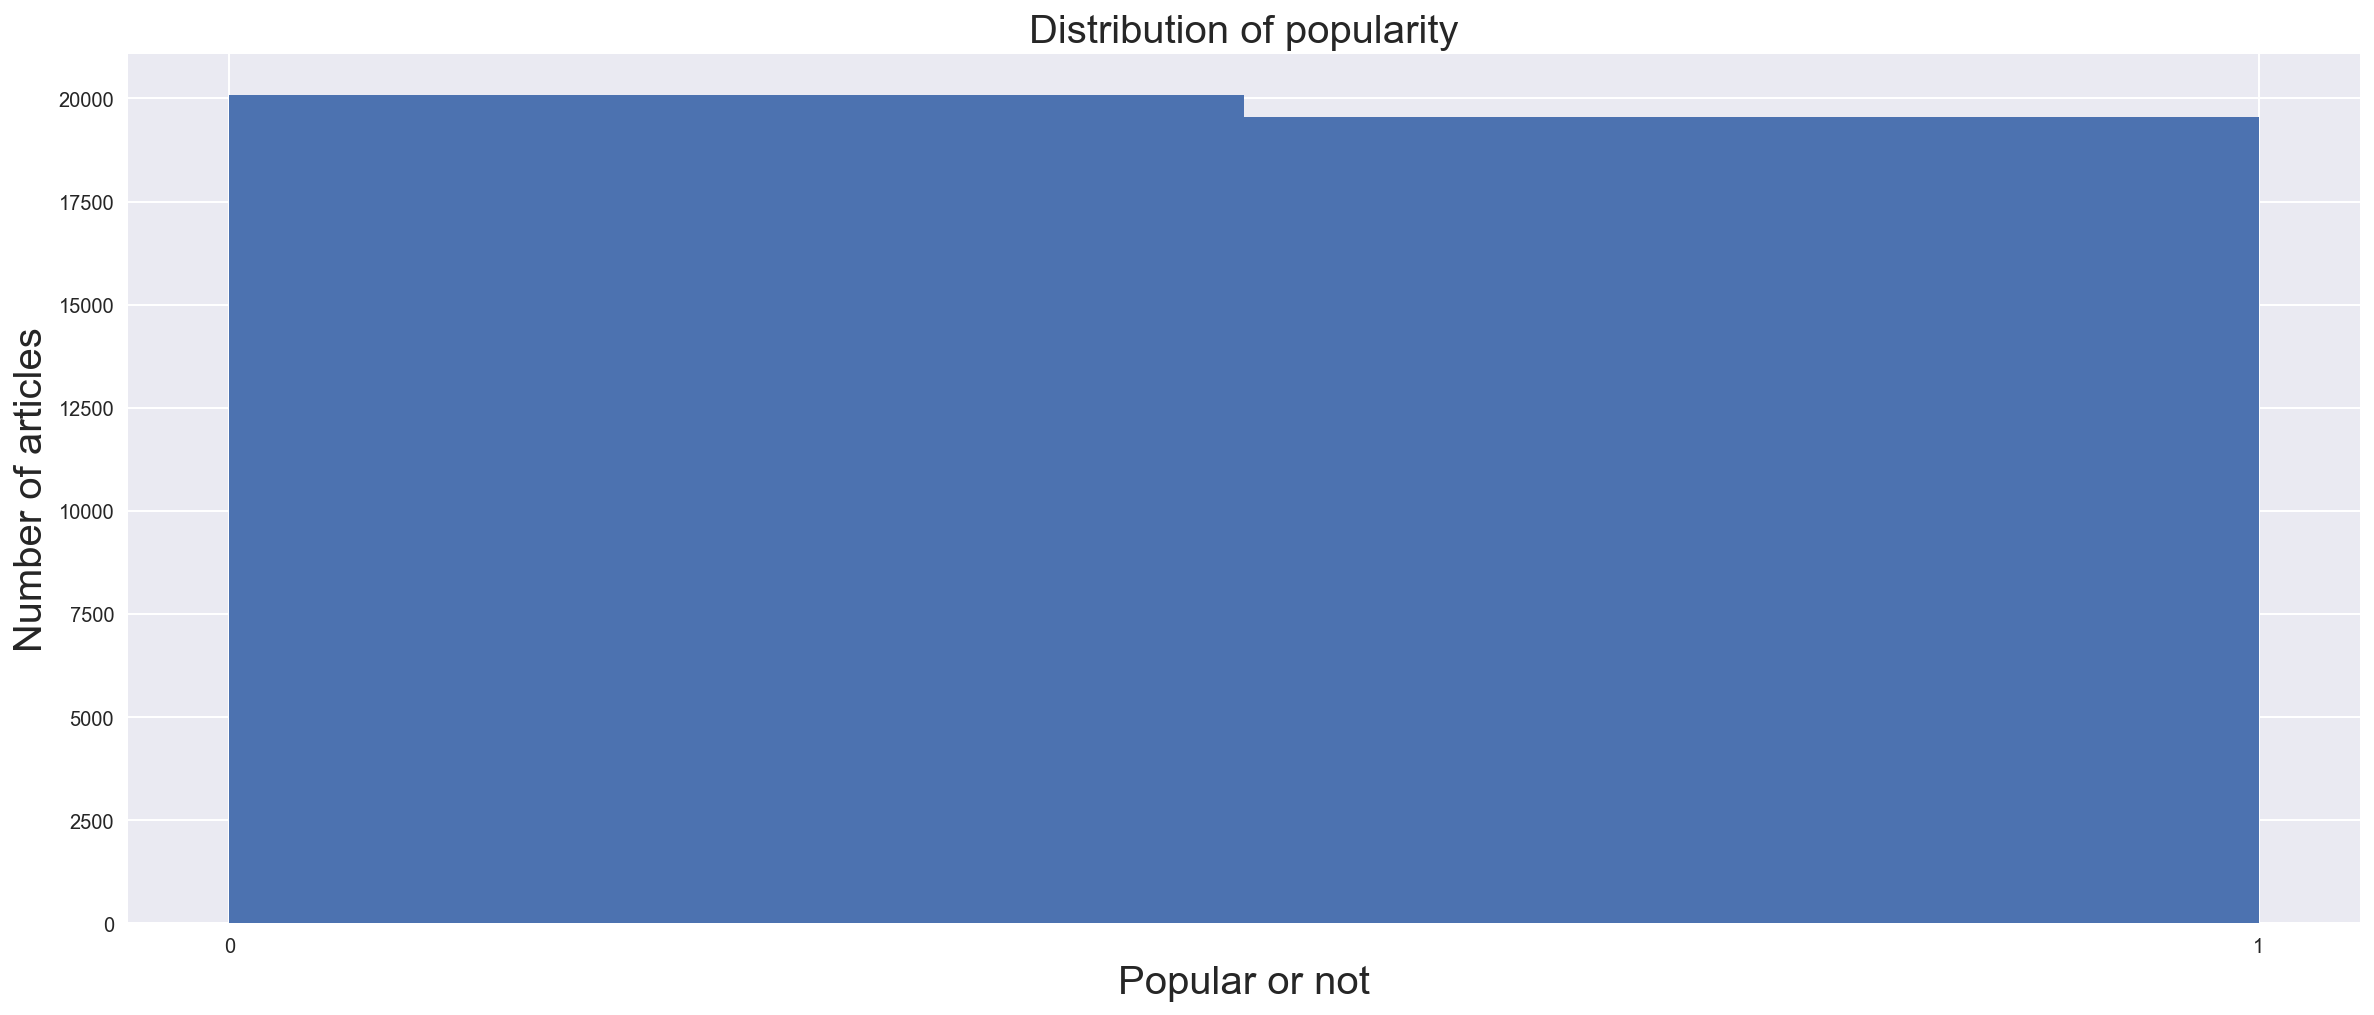

In [9]:
def plot_pop_distribution():
    plot_data = df['target_p50']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

In [10]:
shares_p90 = df['shares'].quantile(0.9)
shares_p90

6200.0

<div class="alert alert-info" style="font-size:150%"><b>target_p90</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 6200 shares (90th percentile)</div>

In [11]:
df['target_p90'] = df['shares'].map(lambda x : 1 if x > shares_p90 else 0)
df[['shares', 'target_p90']].head()

,shares,target_p90
0,593,0
1,711,0
2,1500,0
3,1200,0
4,505,0


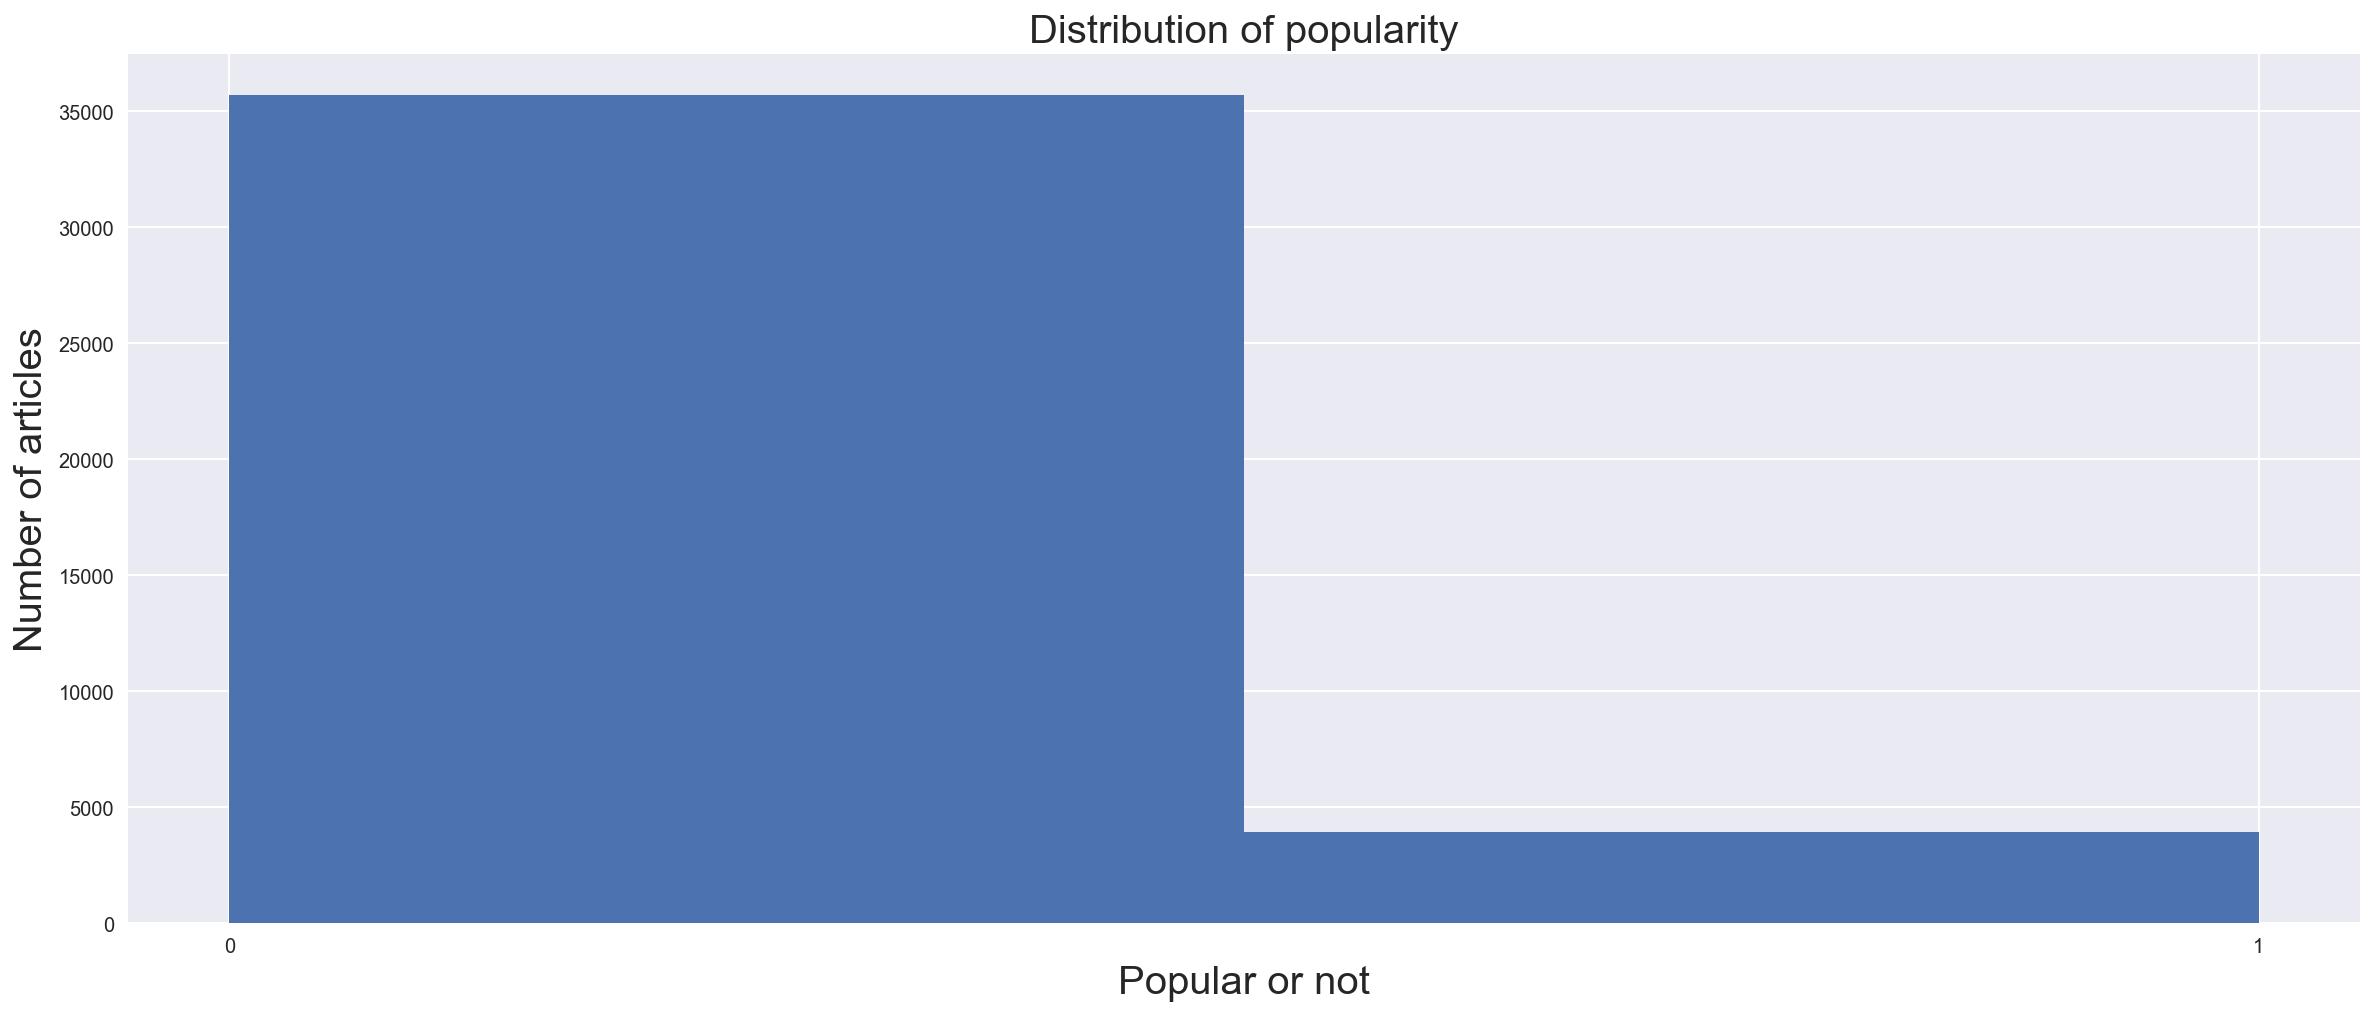

In [12]:
def plot_pop_distribution():
    plot_data = df['target_p90']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

<div class="alert alert-info" style="font-size:150%"><b>target_categories</b>: Instead of predicting share count, we predict whether an article's share count will be within the 1st - 25th percentile, 25th - 50th percentile, 50th - 75th percentile of 75th - 99th percentile.</div>

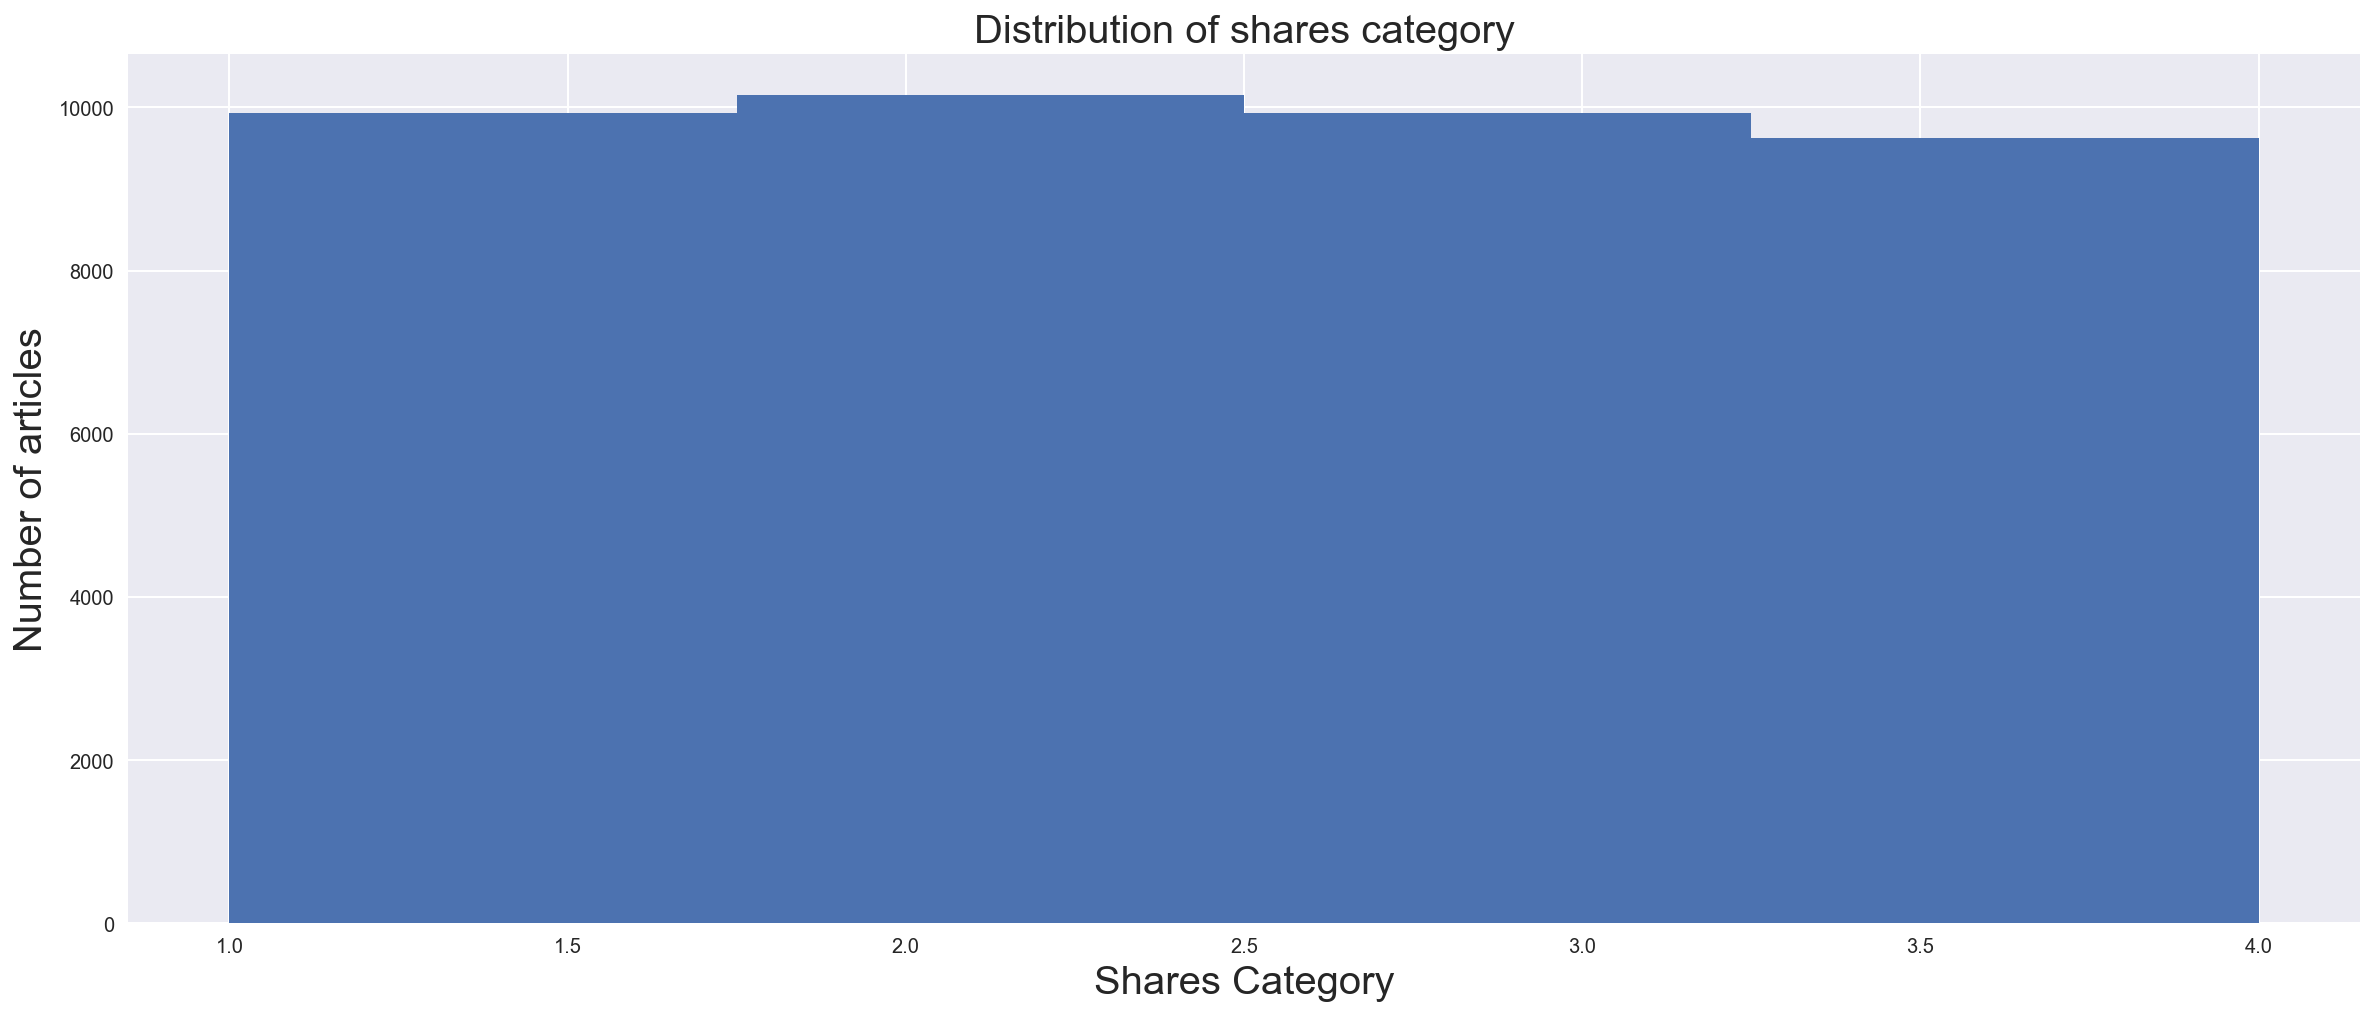

In [13]:
p_25 = df['shares'].quantile(0.25)
p_50 = df['shares'].quantile(0.50)
p_75 = df['shares'].quantile(0.75)
df['target_categories'] = df['shares'].apply(lambda x: 4 if x > p_75 else (3 if x > p_50 else (2 if x > p_25 else 1)))
def plot_shares_cat_distribution():
    plot_data = df['target_categories']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of shares category', fontsize = d_fontsize)
    ax.set_xlabel('Shares Category', fontsize = d_fontsize)
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=4);
plot_shares_cat_distribution()

<div class="alert alert-info" style="font-size:150%"><b>Social Media shares by weekday</b></div>

Text(0.5,1,'Social media shares vs weekday')

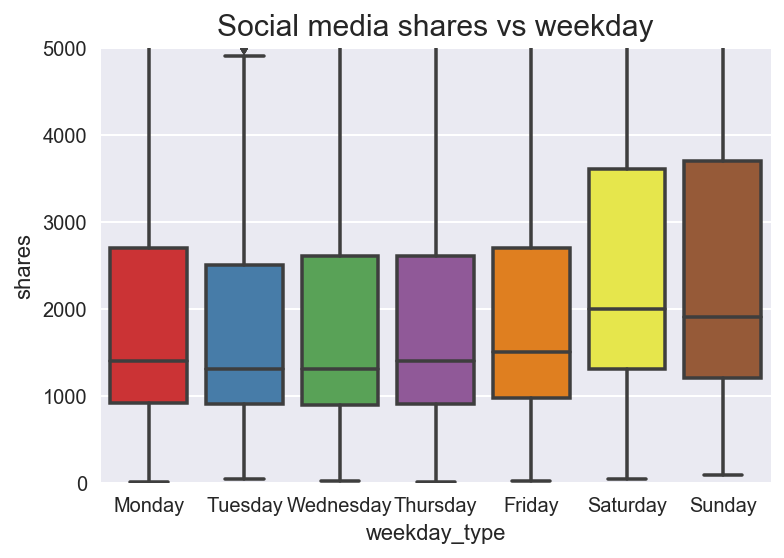

In [14]:
sns.boxplot(data=df1, x='weekday_type',y='shares',\
            palette='Set1')
ax = plt.gca()
ax.set_ylim([0, 5000])  
ax.set_title("Social media shares vs weekday",size=15)

<div class="alert alert-info" style="font-size:150%"><b>3. Correlation with Target</b></div>

In [15]:
# linear correlation
df_without_y = df[[x for x in df.columns if x not in ['target_categories', 'target_p50', 'target_p90']]]
top_correlated = df_without_y.corr(method = 'spearman')['shares'].abs().sort_values()[::-1]
predictors_t5 = list(top_correlated[1:6].keys())
predictors_t10 = list(top_correlated[1:11].keys())
predictors_all = list(top_correlated[1::].keys())

predictors_t5

['kw_avg_avg',
 'kw_max_avg',
 'self_reference_avg_sharess',
 'self_reference_min_shares',
 'self_reference_max_shares']

<div class="alert alert-info" style="font-size:150%">These are the top 5 predictor variables with strong linear correlation. </div>

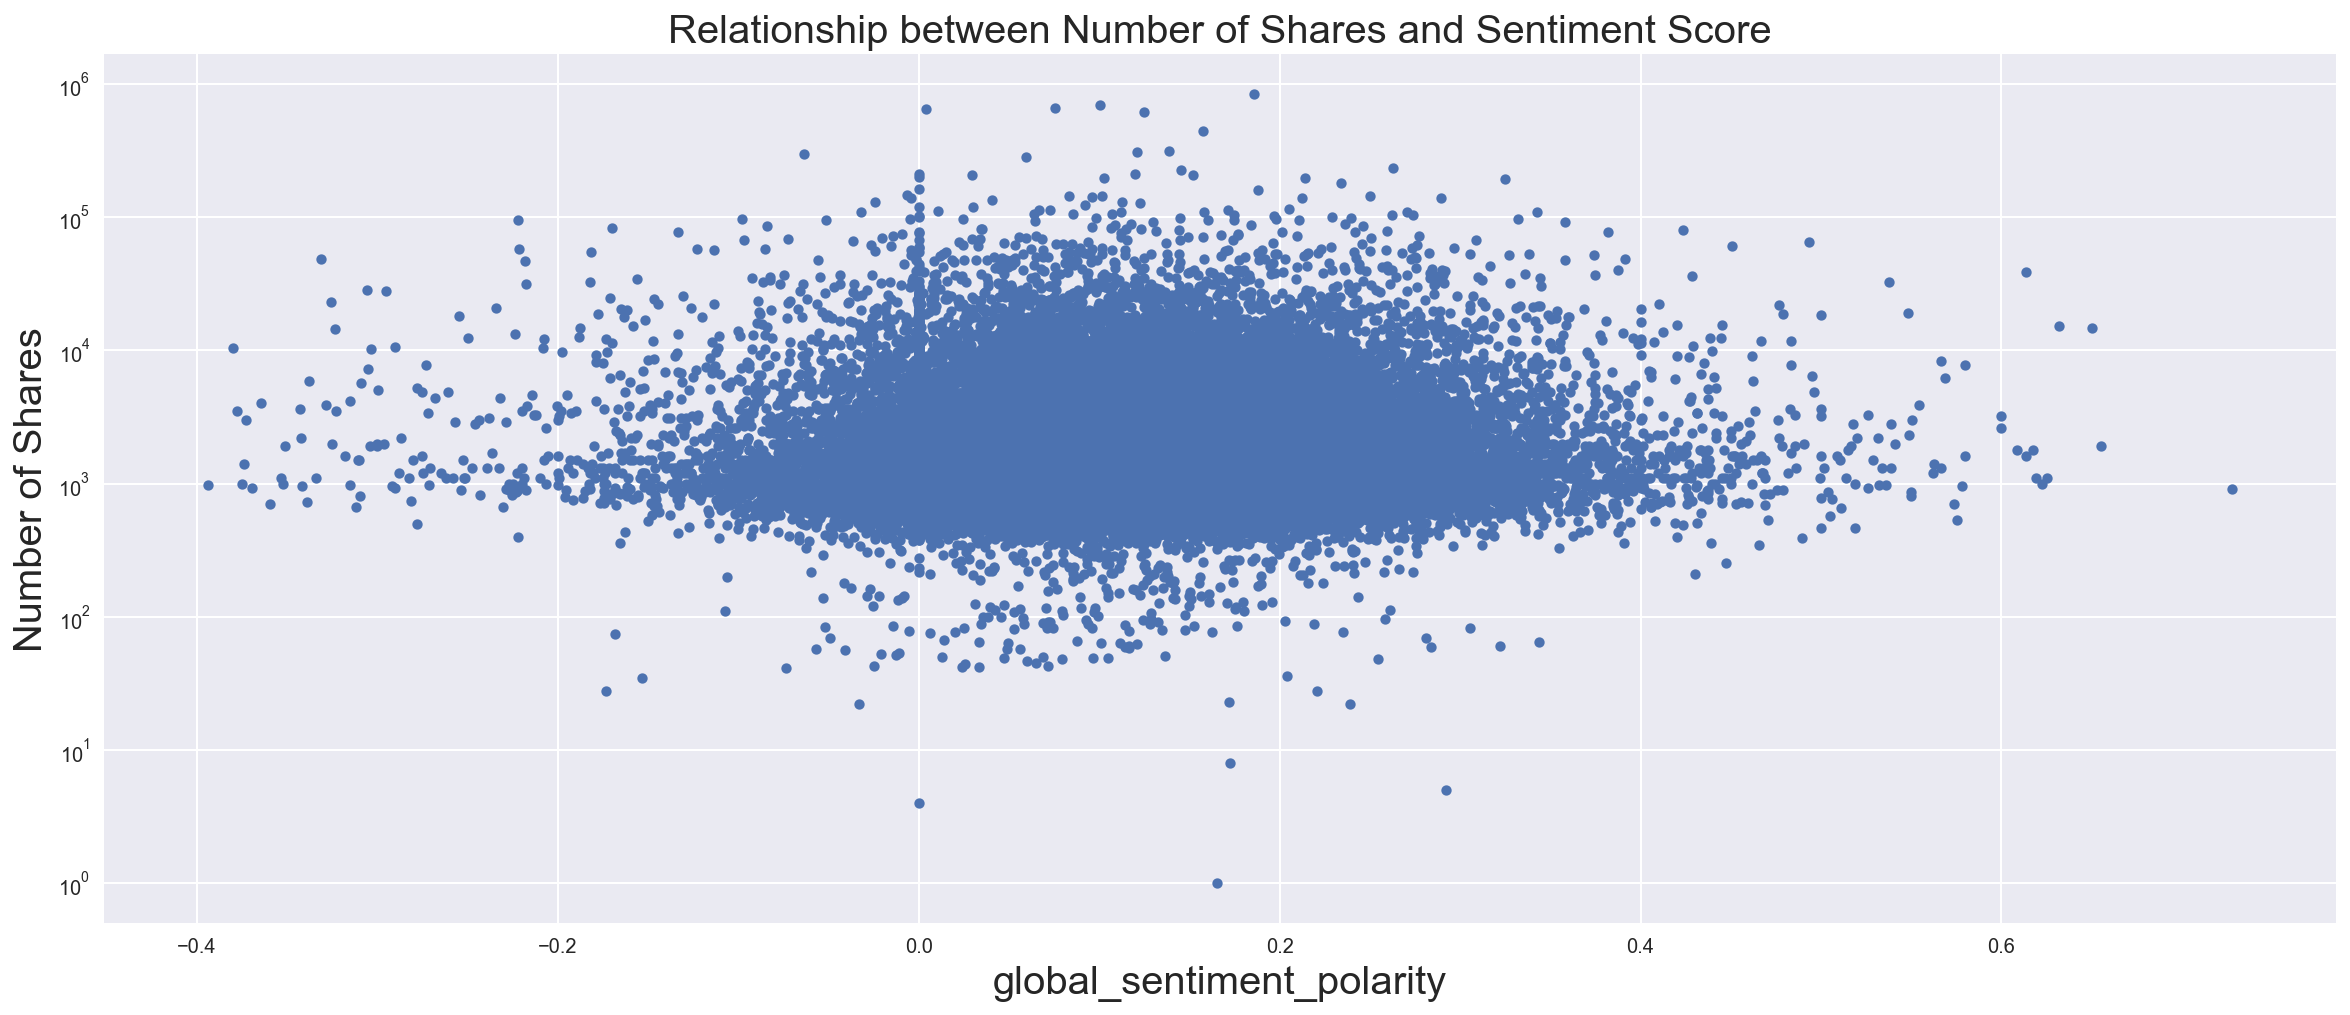

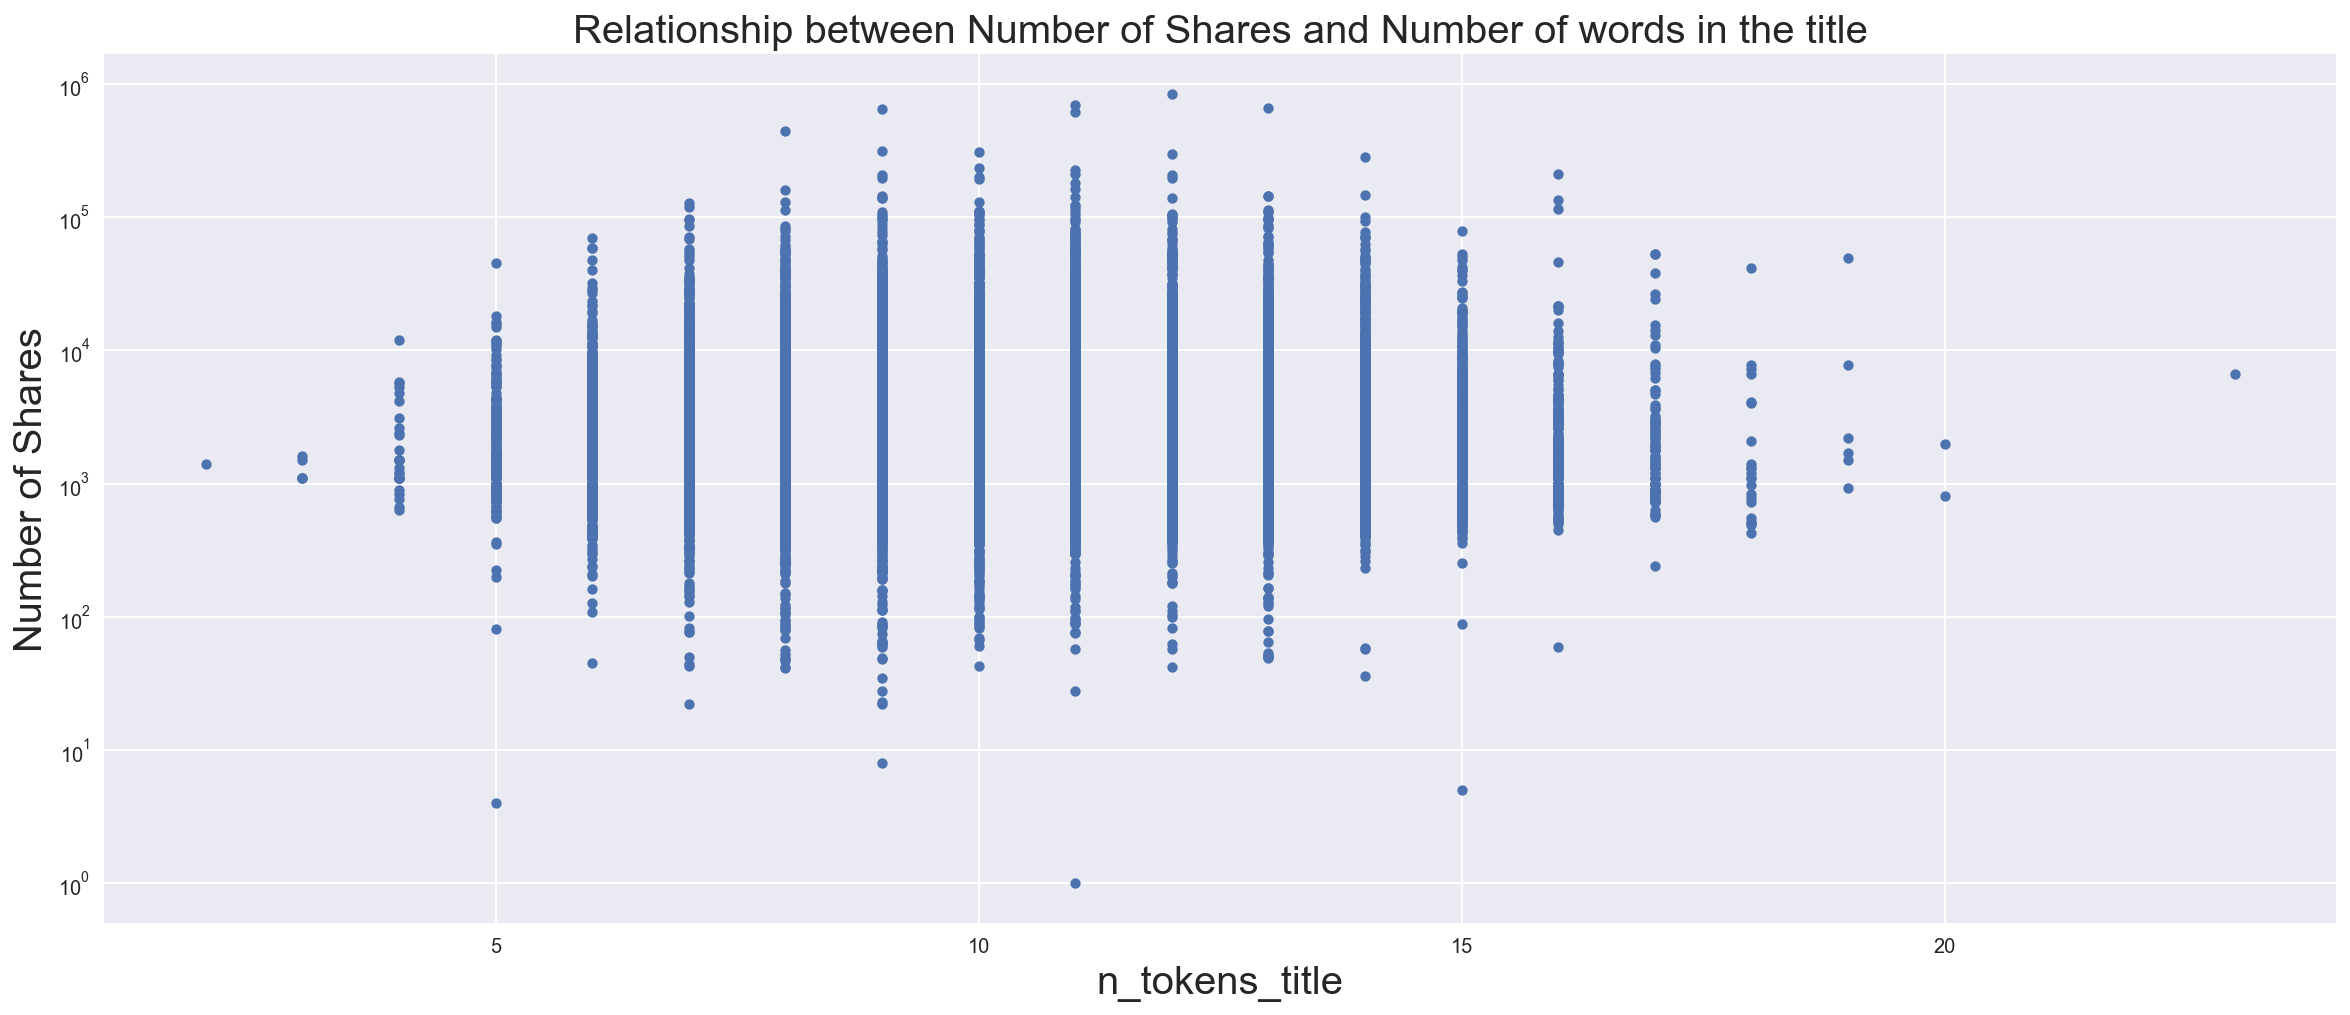

In [16]:
# non-linear correlation
non_linear_corr_vars = [
    'global_sentiment_polarity',
    'n_tokens_title', 
]

non_linear_corr_names = {
    'global_sentiment_polarity': 'Sentiment Score',
    'n_tokens_title': 'Number of words in the title'
}

for column_name in non_linear_corr_vars:
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.scatter(x = df[column_name], y = df['shares'], s = 10, linewidths = 2);
    ax.set_title('Relationship between {y} and {x}'.format(
        x = non_linear_corr_names[column_name], 
        y = target_name
    ), 
    fontsize = d_fontsize)
    ax.set_ylabel(target_name, fontsize = d_fontsize)
    ax.set_xlabel(column_name, fontsize = d_fontsize)
    plt.show()

<div class="alert alert-info" style="font-size:150%">Articles with 
<li>a neutral to slightly positive tone, and</li>
<li>title containing 7 to 13 words</li>
has higher share counts. </div>

<div class="alert alert-info" style="font-size:150%"><b>4. Seperate into predictors and target values</b></div>

In [17]:
df_predictors = df[[x for x in df.columns if x not in ['url', 'target_p50', 'target_p90', 'target_categories']]]
df_predictors.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731,12,219,0.663594,1.0,0.815385,4,2,1,0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731,9,255,0.604743,1.0,0.791946,3,1,1,0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731,9,211,0.575130,1.0,0.663866,3,1,1,0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731,9,531,0.503788,1.0,0.665635,9,0,1,0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [18]:
df_targets = df[['shares', 'target_p50', 'target_p90', 'target_categories']]
df_targets.head()

,shares,target_p50,target_p90,target_categories
0,593,0,0,1
1,711,0,0,1
2,1500,1,0,3
3,1200,0,0,2
4,505,0,0,1


<div class="alert alert-info" style="font-size:150%"><b>5. Normalise the data</b></div>

In [19]:
def normalise_predictors(df, scaler_name='mms'):
    scaler = None
    if scaler_name == 'mms':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    elif scaler_name == 'rb': 
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
    return scaler.fit_transform(df)

df_mms = normalise_predictors(df_predictors, 'mms')
df_mms

array([[1.00000000e+00, 4.76190476e-01, 2.58437574e-02, ...,
        0.00000000e+00, 1.87500000e-01, 7.02004864e-04],
       [1.00000000e+00, 3.33333333e-01, 3.00920463e-02, ...,
        1.00000000e+00, 0.00000000e+00, 8.41931509e-04],
       [1.00000000e+00, 3.33333333e-01, 2.48996932e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.77754272e-03],
       ...,
       [0.00000000e+00, 3.80952381e-01, 5.21595468e-02, ...,
        9.09090909e-02, 1.36363636e-01, 2.25187033e-03],
       [0.00000000e+00, 1.90476190e-01, 8.04814727e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.30321511e-03],
       [0.00000000e+00, 3.80952381e-01, 1.85272599e-02, ...,
        3.33333333e-01, 2.50000000e-01, 1.54037892e-03]])

<div class="alert alert-info" style="font-size:150%"><b>6. Define the model functions</b></div>

In [20]:
# define the functions
def model_linear_regression(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_lasso_alpha(X, y):
    from sklearn.linear_model import LassoCV  
    ls = LassoCV(cv = 10, n_alphas = 500, random_state = 42)
    ls.fit(X, y)
    return ls.alpha_

def model_lasso(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_lasso_alpha(X, y)
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import cross_val_score
    
    ls = Lasso(alpha = alpha)
    scores = cross_val_score(ls, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_ridge_alpha(X, y):
    from sklearn.linear_model import RidgeCV  
    ls = RidgeCV(alphas = np.linspace(0.1, 10, 20), cv = 10)
    ls.fit(X, y)
    return ls.alpha_

def model_ridge(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_ridge_alpha(X, y)
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import cross_val_score
    
    rd = Ridge(alpha = alpha)
    scores = cross_val_score(rd, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_elasticnet_alpha_l1ratio(X, y):
    from sklearn.linear_model import ElasticNetCV  
    en = ElasticNetCV(alphas = np.linspace(0.1, 10, 20), n_alphas = 20, cv = 10)
    en.fit(X, y)
    return en.alpha_, en.l1_ratio

def model_elasticnet(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha, l1_ratio = get_elasticnet_alpha_l1ratio(X, y)
    from sklearn.linear_model import ElasticNet
    from sklearn.model_selection import cross_val_score
    
    en = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
    scores = cross_val_score(en, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

In [21]:
store_R2 = [] # scaler, number_of_predictor, model_type, R2, y_type

<div class="alert alert-info" style="font-size:150%"><b>7. Run the model for each target variable, each predictor (5, 10, all), and each normalised predictor (mms, rb)</b></div>

In [22]:
predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='main loop'):
    df_temp = predictors[i]

    column_length = df_targets.shape[1]
    for column_index in tnrange(column_length, desc='2nd loop'):
        y = df_targets.iloc[:, column_index]

        r2_mms = model_ridge(df_temp, y, scaler_name='mms')
        r2_rb = model_ridge(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'ridge', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'ridge', y.name, r2_rb])

        r2_mms = model_lasso(df_temp, y, scaler_name='mms')
        r2_rb = model_lasso(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'lasso', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'lasso', y.name, r2_rb])

        r2_mms = model_elasticnet(df_temp, y, scaler_name='mms')
        r2_rb = model_elasticnet(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'elastic', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'elastic', y.name, r2_rb])

        r2_mms = model_linear_regression(df_temp, y, scaler_name='mms')
        r2_rb = model_linear_regression(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'linearRegression', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'linearRegression', y.name, r2_rb])

    
print(store_R2)



[['mms', 5, 'ridge', 'shares', 0.015400107909628546], ['rb', 5, 'ridge', 'shares', 0.014925760454626269], ['mms', 5, 'lasso', 'shares', 0.015346360060087282], ['rb', 5, 'lasso', 'shares', 0.015179126691988176], ['mms', 5, 'elastic', 'shares', -0.0008518918570541101], ['rb', 5, 'elastic', 'shares', 0.015030636162159994], ['mms', 5, 'linearRegression', 'shares', 0.014923708441612482], ['rb', 5, 'linearRegression', 'shares', 0.014923708441612482], ['mms', 5, 'ridge', 'target_p50', 0.02267329345695488], ['rb', 5, 'ridge', 'target_p50', 0.022630804679382766], ['mms', 5, 'lasso', 'target_p50', 0.022660799409451527], ['rb', 5, 'lasso', 'target_p50', 0.02266144095613215], ['mms', 5, 'elastic', 'target_p50', -0.012008714931147723], ['rb', 5, 'elastic', 'target_p50', 0.005675367386770191], ['mms', 5, 'linearRegression', 'target_p50', 0.022628263541894744], ['rb', 5, 'linearRegression', 'target_p50', 0.022628263541894657], ['mms', 5, 'ridge', 'target_p90', 0.029502632196265043], ['rb', 5, 'ridge

In [23]:
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head()

,ScalerType,NumPredictor,ModelType,Target,R2
90,mms,59,lasso,target_categories,0.112140
88,mms,59,ridge,target_categories,0.110415
56,mms,10,ridge,target_categories,0.097340
57,rb,10,ridge,target_categories,0.097297
62,mms,10,linearRegression,target_categories,0.097295


<div class="alert alert-info" style="font-size:150%">9. Try Random Forest, Adaptive Boosting, SVM, Neutral Network </div>

In [24]:
# import tensorflow as tf
# from tensorflow import keras - cannot use as tensorflow havent support python 3.7

In [25]:
print('test')
def model_randomForest(X, y, scaler_name):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    X = normalise_predictors(X, scaler_name)
    rfc = RandomForestClassifier()
    results = cross_val_score(rfc, X = X, y = y, cv=10)
    return np.mean(results)

predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='main loop'):
    df_temp = predictors[i]

    column_length = df_targets.shape[1]
    for column_index in tnrange(column_length, desc='2nd loop'):
        y = df_targets.iloc[:, column_index]
        
        r2_mms = model_randomForest(df_temp, y, scaler_name='mms')
        r2_rb = model_randomForest(df_temp, y, scaler_name='rb')

        store_R2.append(['mms', df_temp.shape[1], 'randomForest', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'randomForest', y.name, r2_rb])


test


In [26]:
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
116,mms,59,randomForest,target_p90,0.896781
117,rb,59,randomForest,target_p90,0.896781
108,mms,10,randomForest,target_p90,0.895167
109,rb,10,randomForest,target_p90,0.894309
101,rb,5,randomForest,target_p90,0.889845
100,mms,5,randomForest,target_p90,0.889819
106,mms,10,randomForest,target_p50,0.592273
107,rb,10,randomForest,target_p50,0.589727
115,rb,59,randomForest,target_p50,0.579390
114,mms,59,randomForest,target_p50,0.577776


<div class="alert alert-info" style="font-size:150%">With R2 = 0.89, Random Forest worked pretty well in predicting share count > 90th percentile using robust scaler and all 59 predictors.</div>

In [27]:
# support vector machine - not linear
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
x_tmp = normalise_predictors(df_predictors[predictors_all], 'rb')
model_svm = LinearSVC()
cross_val_score(model_svm, X = x_tmp, y = df_targets.iloc[:, 2], cv = 5)

array([0.24501892, 0.73628453, 0.88270904, 0.88017154, 0.89997477])

In [28]:
np.mean([0.89457755, 0.73149199, 0.86719637, 0.90047931, 0.8997225])

0.858693544

<div class="alert alert-info" style="font-size:150%">Support Vector Machine Worked pretty well too, but still not as good as random forest of R2=0.89. Thus, lets investigate randomforest with target_p90, scaler=robust and numPredictor = all 59.</div>

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_predictors[predictors_all], df_targets.iloc[:, 2], test_size=0.33, random_state=42)
X_train = normalise_predictors(X_train, 'rb')
X_test = normalise_predictors(X_test, 'rb')
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.896889092715738

In [30]:
rfc.feature_importances_

array([0.03874628, 0.03905416, 0.02385192, 0.0260219 , 0.02395258,
       0.00273518, 0.0279654 , 0.00284291, 0.00311078, 0.00157534,
       0.02785604, 0.00271383, 0.02259084, 0.00270145, 0.00282916,
       0.02758091, 0.02445702, 0.02202486, 0.01610879, 0.02507863,
       0.02293261, 0.01042375, 0.01944338, 0.02547149, 0.0288626 ,
       0.03438079, 0.01646916, 0.02801829, 0.01843132, 0.00933356,
       0.01995936, 0.02456256, 0.03183584, 0.01046078, 0.00306161,
       0.01084057, 0.02378964, 0.00245713, 0.00331423, 0.01292888,
       0.01938822, 0.01218507, 0.0285737 , 0.01321352, 0.00332424,
       0.02712919, 0.00518909, 0.0211593 , 0.02530183, 0.00421903,
       0.00174281, 0.02347494, 0.01357715, 0.00293638, 0.0234323 ,
       0.02279763, 0.00525029, 0.01218764, 0.01414212])

In [31]:
feature_importances_ = rfc.feature_importances_
feature_importance = {}
for index, name in enumerate(df_predictors[predictors_all]):
    feature_importance[name] = feature_importances_[index]

sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_value[:10] # these are the top 10 predictor vars

[('kw_max_avg', 0.039054157432470885),
 ('kw_avg_avg', 0.03874627551344447),
 ('LDA_03', 0.03438078608372195),
 ('LDA_04', 0.03183584304916477),
 ('LDA_01', 0.028862598957606234),
 ('kw_avg_max', 0.02857370312080606),
 ('average_token_length', 0.028018294103724146),
 ('LDA_02', 0.027965396192555975),
 ('global_subjectivity', 0.027856035887817498),
 ('kw_avg_min', 0.027580908327377113)]

<div class="alert alert-info" style="font-size:150%">The top 3 predictor variables are kw_avg_avg, kw_max_avg, and LDA_04</div>

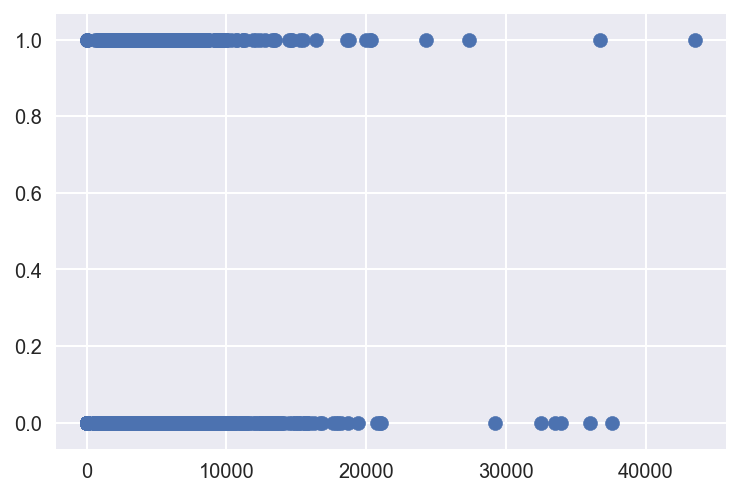

In [32]:
plt.scatter(df['kw_avg_avg'], df_targets.iloc[:, 2])

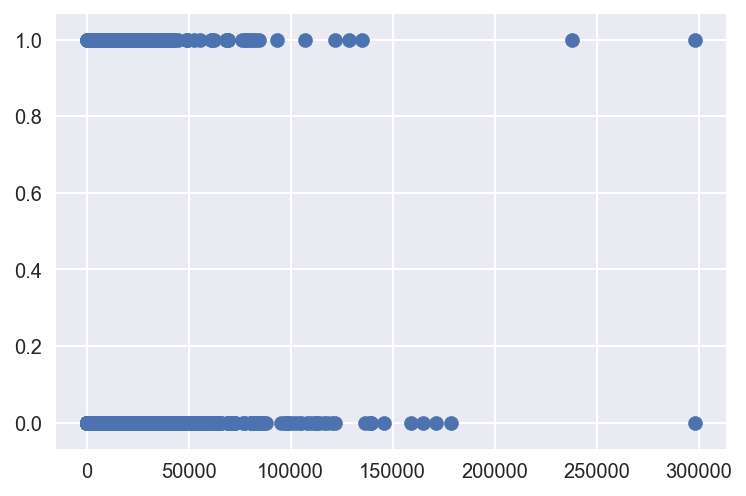

In [33]:
plt.scatter(df['kw_max_avg'], df_targets.iloc[:, 2])

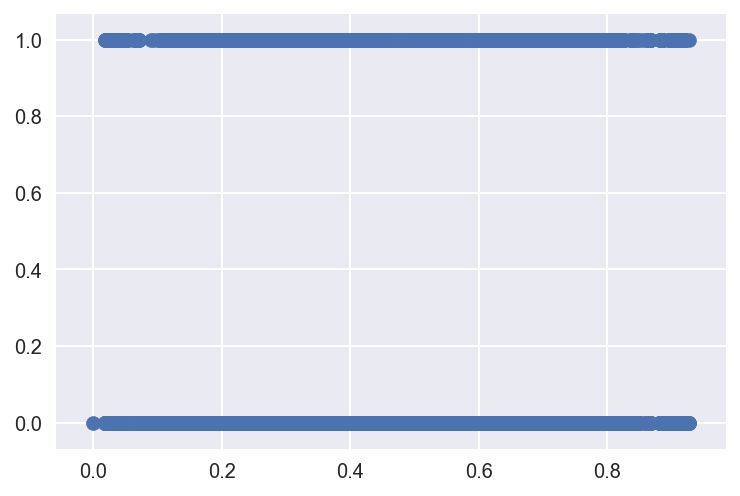

In [34]:
plt.scatter(df['LDA_04'], df_targets.iloc[:, 2])

In [35]:
# # as python 3.7 doesnt have tensorflow, lets build tensorflow our way.
# class NeuralNetwork:
#     def __init__(self, x, y):
#         self.input      = x
#         self.weights1   = np.random.rand(x.shape[1],4) 
#         self.weights2   = np.random.rand(4,1)                 
#         self.y          = y
#         self.output     = np.zeros(self.y.shape)

#     def feedforward(self):
#         def sigmoid(x):
#             x = x.astype(float)
#             print(x.dtype)
#             import numpy as np
#             s = 1/(1+np.exp(-x))
#             return s
#         self.layer1 = sigmoid(np.dot(self.input, self.weights1))
#         self.output = sigmoid(np.dot(self.layer1, self.weights2))

#     def backprop(self):
#         def sigmoid(x):
#             import numpy as np
#             s = 1/(1+np.exp(-x))
#             return s
        
#         def sigmoid_derivative(x):
#             return sigmoid(x)*(1-sigmoid(x))
        
#         # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
#         d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
#         d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

#         # update the weights with the derivative (slope) of the loss function
#         self.weights1 += d_weights1
#         self.weights2 += d_weights2
        
# # testing
# # nn = NeuralNetwork(pd.DataFrame([[0,0,1], [0,1,1],[1,0,1], [1,1,1]]), pd.DataFrame([0,1,1,0])) # test 
# # for i in range(5000):
# #     nn.feedforward()
# #     nn.backprop()
# # print(nn.output, nn.y)

# model_nn = NeuralNetwork(df_predictors[predictors_all], df_targets.iloc[:, 2])
# for i in range(5000):
#     model_nn.feedforward()
#     model_nn.backprop()
# print(model_nn.output, model_nn.y)

In [36]:
# # what are the variables that caused the prediction?
# # pd.DataFrame([(predictor_vars), rfc.feature_importances_])
# feature_importances_ = rfc.feature_importances_
# feature_importance = {}
# for index, name in enumerate(predictor_vars):
#     feature_importance[name] = feature_importances_[index]

# sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
# sorted_by_value[:10] # these are the top 10 predictor vars
# '''
# [('kw_avg_avg', 0.041648549925375644),
#  ('kw_max_avg', 0.03796269752791201),
#  ('self_reference_min_shares', 0.03209670590593529),
#  ('LDA_02', 0.03192396892278292),
#  ('timedelta', 0.031153999073768902),
#  ('LDA_04', 0.02864868771040057),
#  ('n_non_stop_unique_tokens', 0.027772663068285852),
#  ('kw_avg_max', 0.027608267341882365),
#  ('n_unique_tokens', 0.027595845841238382),
#  ('LDA_03', 0.027371986619792055)]
#  '''

In [37]:
# Random Forest on share_category
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# not_predictors = ['shares', 'url', 'pop_above_median', 'shares_cat', 'predicted', 'pop_above_75_percentile']
# predictor_vars = [x for x in df.columns if x not in not_predictors]
# rfc = RandomForestClassifier()
# results = cross_val_score(rfc, X = df[predictor_vars], y = df['shares_cat'], cv=10)
# results # results are much worse if there are more categories
# array([0.25895108, 0.2491175 , 0.31710394, 0.33526741, 0.32088799,
#        0.33224016, 0.33249243, 0.3413219 , 0.3327447 , 0.30978809])

In [42]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [38]:
# Random Forest on pop_above_75_percentile
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
not_predictors = ['shares', 'url', 'pop_above_median', 'shares_cat', 'predicted', 'pop_above_75_percentile']
predictor_vars = [x for x in df.columns if x not in not_predictors]
rfc = RandomForestClassifier()
results = cross_val_score(rfc, X = df[predictor_vars], y = df['pop_above_75_percentile'], cv=10)
results # results are much worse if there are more categories

KeyError: 'pop_above_75_percentile'

In [39]:
rfc.fit(df[predictor_vars], df['pop_above_75_percentile'])
feature_importances = rfc.feature_importances_

KeyError: 'pop_above_75_percentile'

In [40]:

sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_value[:10] # these are the top 10 predictor vars

[('kw_max_avg', 0.039054157432470885),
 ('kw_avg_avg', 0.03874627551344447),
 ('LDA_03', 0.03438078608372195),
 ('LDA_04', 0.03183584304916477),
 ('LDA_01', 0.028862598957606234),
 ('kw_avg_max', 0.02857370312080606),
 ('average_token_length', 0.028018294103724146),
 ('LDA_02', 0.027965396192555975),
 ('global_subjectivity', 0.027856035887817498),
 ('kw_avg_min', 0.027580908327377113)]

In [41]:
df['kw_avg_avg']

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
5           0.000000
6           0.000000
7           0.000000
8           0.000000
9           0.000000
10          0.000000
11          0.000000
12          0.000000
13          0.000000
14          0.000000
15          0.000000
16          0.000000
17          0.000000
18          0.000000
19          0.000000
20          0.000000
21          0.000000
22          0.000000
23          0.000000
24          0.000000
25          0.000000
26          0.000000
27          0.000000
28          0.000000
29          0.000000
            ...     
39614    2176.103343
39615    3605.376162
39616    3835.453639
39617    2125.697028
39618    2833.317260
39619    2704.113469
39620    1674.398279
39621    3720.474658
39622    1908.414298
39623    2007.708083
39624    3240.673969
39625    2824.660363
39626    2883.640499
39627    1996.065900
39628    2263.370238
39629    5288.236851
39630    1575